In [3]:
from netCDF4 import Dataset
import numpy as np
from advectionGP.sensors import RemoteSensingModel

# Load the NetCDF file
file_path = r"C:\Users\Nur Izfarwiza\Documents\Dissertation\AOD\MERRA2_400.inst3_2d_gas_Nx.20191001.nc4"
dataset = Dataset(file_path, 'r')
sensors = RemoteSensingModel(num_particles=3)

from pyproj import Proj, Transformer

# Your UTM projection (Zone 56S)
proj_utm = Proj(proj='utm', zone=56, south=True, ellps='WGS84')
proj_wgs84 = Proj(proj='latlong', datum='WGS84')
transformer = Transformer.from_proj(proj_utm, proj_wgs84)

# Convert all (x, y) to (lon, lat)
sensor_latlons = []
for poly in sensors.grid_polygons:
    centroid = poly.centroid
    x, y = centroid.xy[0][0], centroid.xy[1][0]
    lon, lat = transformer.transform(x, y)
    sensor_latlons.append((lat, lon))



In [4]:
aod_times = dataset.variables['time'][:]  # → [0, 180, 360, ..., 1260]
# Units: minutes since 2019-10-01 00:00:00


C:\Users\Nur Izfarwiza\AppData\Local\Temp\ipykernel_42044\1509249724.py:1: RuntimeWarning: invalid value encountered in cast
  aod_times = dataset.variables['time'][:]  # → [0, 180, 360, ..., 1260]
C:\Users\Nur Izfarwiza\AppData\Local\Temp\ipykernel_42044\1509249724.py:1: UserWarning: WARNING: valid_range not used since it
cannot be safely cast to variable data type
  aod_times = dataset.variables['time'][:]  # → [0, 180, 360, ..., 1260]


In [7]:
# Choose the closest AOD time index to your sensor t_start
t_start = 1260 #(end of day)
t_index = np.argmin(np.abs(aod_times - t_start))  # t_start = 1260 (end of day)


In [8]:
lats = dataset.variables['lat'][:]
lons = dataset.variables['lon'][:]
aod_data = dataset.variables['AODANA'][t_index]  # shape (361, 576)

Y = []
for lat, lon in sensor_latlons:
    lat_idx = np.argmin(np.abs(lats - lat))
    lon_idx = np.argmin(np.abs(lons - lon))
    value = aod_data[lat_idx, lon_idx]
    Y.append(value)


In [9]:
Y = np.array(Y)
Y = np.nan_to_num(Y, nan=0.0)
Y = (Y - np.min(Y)) / (np.max(Y) - np.min(Y) + 1e-6)


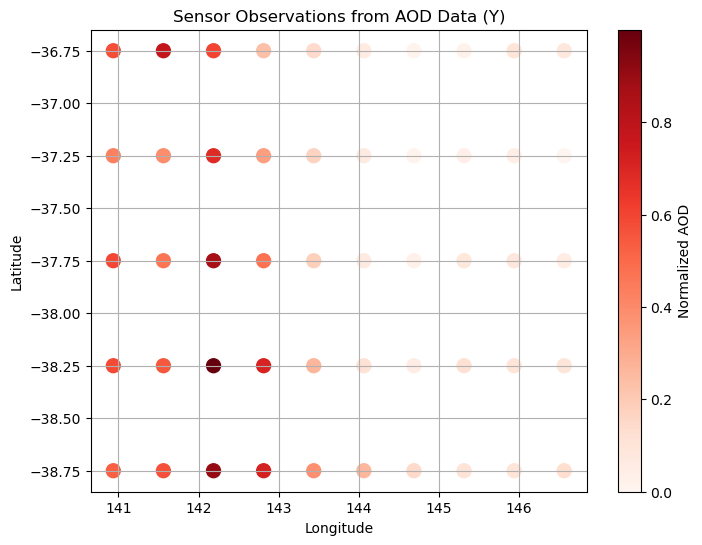

In [10]:
import matplotlib.pyplot as plt

lons_plot = [lon for lat, lon in sensor_latlons]
lats_plot = [lat for lat, lon in sensor_latlons]

plt.figure(figsize=(8, 6))
plt.scatter(lons_plot, lats_plot, c=Y, cmap='Reds', s=100)
plt.colorbar(label='Normalized AOD')
plt.title('Sensor Observations from AOD Data (Y)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True)
plt.show()
